In [19]:
%reload_ext autoreload
%autoreload 2

import scipy as sp
import numpy as np
import pyhf
import numbers
import matplotlib.pyplot as plt
from publik import modifier
from publik import plot

In [20]:
def null_dist(x, y, a=1., b=1.):
    if not isinstance(x, numbers.Number) and not isinstance(x, numbers.Number):
        x,y = np.meshgrid(x, y)
    return a*x**2 + b*y**2

def alt_dist(x, y, a=2., b=0.5):
    return null_dist(x, y, a, b)


In [21]:
xbinning = np.linspace(0., 10., 5)
ybinning = np.linspace(4., 8., 4)

binning = [xbinning, ybinning]

In [22]:
ones = np.ones((4,len(xbinning)-1,len(ybinning)-1))
mapping_dist = np.array([m*(len(ones)-i)  for i,m in enumerate(ones)])
mapping_dist[0,:,1] = 2
mapping_dist[1,:,2] = 4
mapping_dist[2,:,0] = 1
mapping_dist

array([[[4., 2., 4.],
        [4., 2., 4.],
        [4., 2., 4.],
        [4., 2., 4.]],

       [[3., 3., 4.],
        [3., 3., 4.],
        [3., 3., 4.],
        [3., 3., 4.]],

       [[1., 2., 2.],
        [1., 2., 2.],
        [1., 2., 2.],
        [1., 2., 2.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [25]:
# Set up the custom modifier
new_params = {
                'a'   :{'inits': (1.,), 'bounds': ((0., 5.),), 'paramset_type': 'unconstrained'},
                'b'   :{'inits': (1.,), 'bounds': ((0., 5.),), 'paramset_type': 'unconstrained'}
            }

cmod = modifier.Modifier(new_params, alt_dist, null_dist, mapping_dist, binning)
cmod.expanded_pyhf

{'custom': (publik.custom_modifier.add.<locals>._builder,
  publik.custom_modifier.add.<locals>._applier),
 'histosys': (pyhf.modifiers.histosys.histosys_builder,
  pyhf.modifiers.histosys.histosys_combined),
 'lumi': (pyhf.modifiers.lumi.lumi_builder, pyhf.modifiers.lumi.lumi_combined),
 'normfactor': (pyhf.modifiers.normfactor.normfactor_builder,
  pyhf.modifiers.normfactor.normfactor_combined),
 'normsys': (pyhf.modifiers.normsys.normsys_builder,
  pyhf.modifiers.normsys.normsys_combined),
 'shapefactor': (pyhf.modifiers.shapefactor.shapefactor_builder,
  pyhf.modifiers.shapefactor.shapefactor_combined),
 'shapesys': (pyhf.modifiers.shapesys.shapesys_builder,
  pyhf.modifiers.shapesys.shapesys_combined),
 'staterror': (pyhf.modifiers.staterror.staterror_builder,
  pyhf.modifiers.staterror.staterror_combined)}

(<Figure size 1400x500 with 4 Axes>,
 array([<Axes: title={'center': 'null distribution'}>,
        <Axes: title={'center': 'alternative distribution'}>], dtype=object))

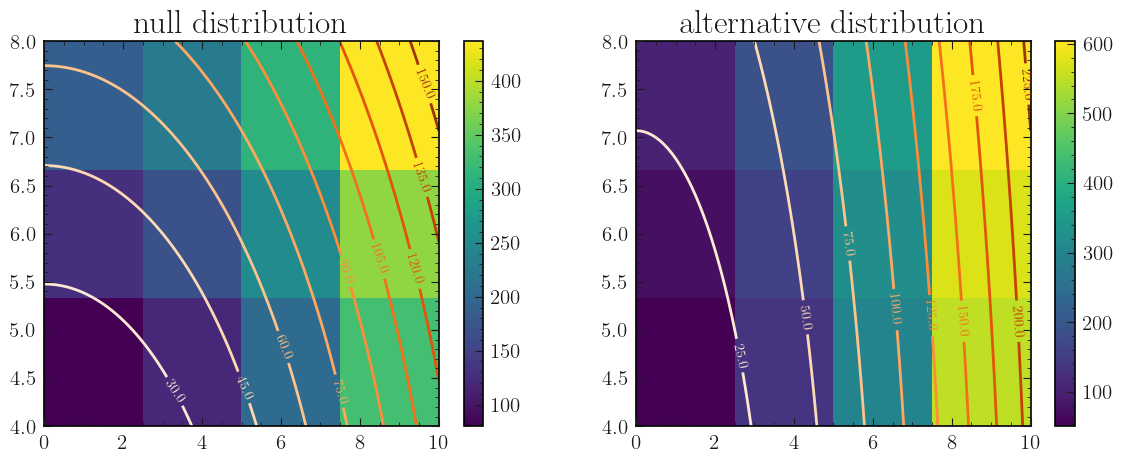

In [26]:
alt_pars=(2., 0.5)
plot.dists(cmod, alt_pars)

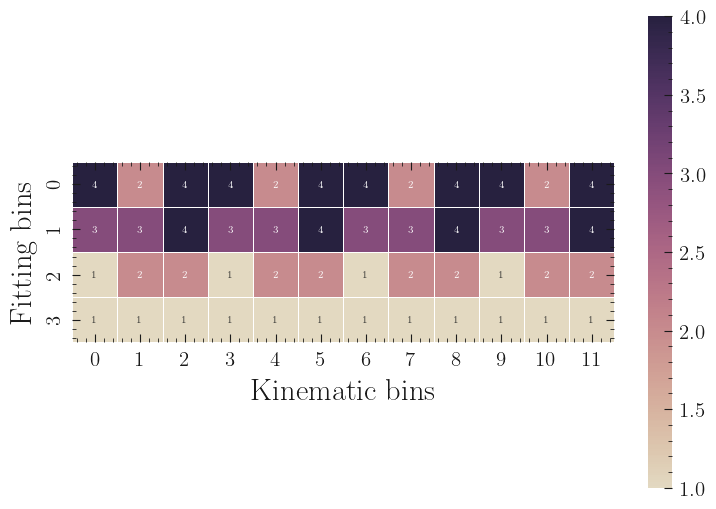

In [27]:
plot.map(cmod)

In [28]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [np.sum(m) for m in mapping_dist],
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            }
          ]
        },
        {
          "name": "background",
          "data": [20*i**2 for i in range(len(mapping_dist))],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [np.sqrt(20*i**2) for i in range(len(mapping_dist))]
            }
          ]
        }
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [i for i in range(len(mapping_dist))]
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [40.0, 40.0, 20.0, 12.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function', 'ibin': [0, 1, 2, 3]}}]},
    {'name': 'background',
     'data': [0, 20, 80, 180],
     'modifiers': [{'name': 'uncorr_bkguncrt',
       'type': 'shapesys',
       'data': [0.0,
        4.47213595499958,
        8.94427190999916,
        13.416407864998739]}]}]}]}

In [29]:
init = model.config.suggested_init()
init[0] = 4.0
init[1] = 1.0
data = list(model.expected_actualdata(init)) + model.config.auxdata

list(data)

[87.31293547591132,
 106.2242274556989,
 122.56775971774324,
 206.14632294135367,
 1.0,
 19.999999999999996,
 79.99999999999999,
 179.99999999999997]

In [30]:
fixed = model.config.suggested_fixed()
fixed[2] = True

best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict = cmod.rotate_pars(best_fit_dict)
best_fit_dict

{'a': 3.9934300731573447,
 'b': 1.0042052272268653,
 'mu': 1.0,
 'uncorr_bkguncrt': [1.0,
  0.9999715712033223,
  0.9999872734133132,
  1.0000046408988705]}

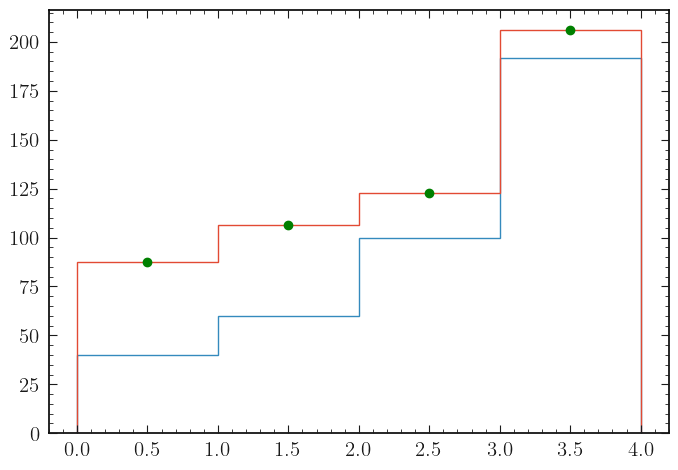

In [31]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()))
plt.stairs(model.expected_actualdata(best_fit))
bin_cents = [0.5, 1.5, 2.5, 3.5]
plt.plot(bin_cents, data[:4], 'og')